In [5]:
import requests     # 2.18.4
import pandas as pd # 0.23.0
import datetime
import io
import re
from timedisagg.td import TempDisagg
from datetime import date
import yfinance as yf

In [17]:
def download_data(key_string_start, key_string_main, start_year, end_year):
    entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/' # Using protocol 'https'
    resource = 'data'           # The resource for data queries is always'data'
    flowRef = key_string_start              # Dataflow describing the data that needs to be returned, exchange rates in this case
    key = key_string_main    # Defining the dimension values, explained below

    # Define the parameters
    parameters = {
        'startPeriod': start_year,  # Start date of the time series
        'endPeriod': end_year     # End of the time series
    }

    request_url = entrypoint + resource + '/'+ flowRef + '/' + key
    
    name_response = requests.get(request_url, params=parameters)

    response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
    
    name = re.findall('Value id="TITLE" value=.+?\"', name_response.text)[0][23::].replace('\"','')

    df = pd.read_csv(io.StringIO(response.text))

    ts = df.filter(['TIME_PERIOD', 'OBS_VALUE'], axis=1)

    ts = ts.set_index('TIME_PERIOD')
    
    full_key_string = key_string_start + "." + key_string_main
    
    ts.to_csv(f"{full_key_string}.csv")
    
    print(name)
    
    ts.plot()
    
    return ts

today = "2021-12-31"

start_date = "2019-01-01"

## 1-Year

Yield curve instantaneous forward rate, 1-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition)


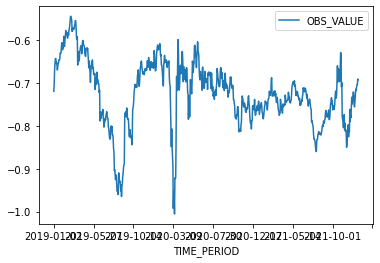

In [18]:
one_year = download_data("YC", "B.U2.EUR.4F.G_N_A.SV_C_YM.IF_1Y", start_date, today) #Daily

## 8-Years

Yield curve instantaneous forward rate, 8-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition)


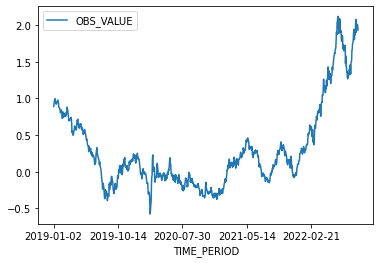

In [5]:
eight_year = download_data("YC", "B.U2.EUR.4F.G_N_A.SV_C_YM.IF_8Y", start_date, today)

## 20-Years

Yield curve instantaneous forward rate, 20-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition)


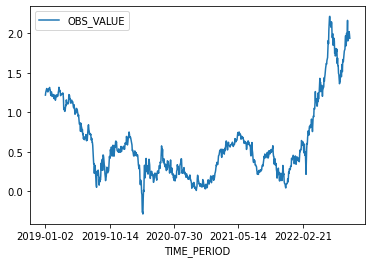

In [6]:
twenty_year = download_data("YC", "B.U2.EUR.4F.G_N_A.SV_C_YM.IF_20Y", start_date, today) 

## CISS

NEW CISS - Composite Indicator of Systemic Stress 


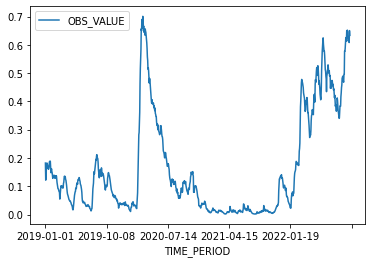

In [13]:
CISS = download_data("CISS", "D.U2.Z0Z.4F.EC.SS_CIN.IDX", start_date, today) 

## EONIA

Rate for the overnight maturity calculated as the euro short-term rate plus a spread of 8.5 basis points


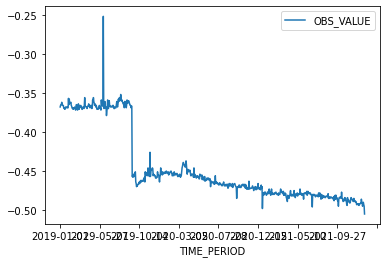

In [15]:
EONIA = download_data("EON", "D.EONIA_TO.RATE", start_date, today)

## Stock data

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

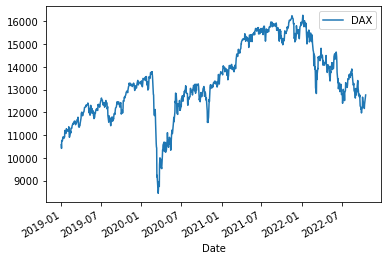

In [11]:
stock = "^GDAXI"

name = "DAX"

stock_data = yf.download(stock, start=start_date, end=today)
stock_dropped = stock_data.drop(labels=["Open", "High", "Low", "Close", "Volume"], axis = 1)
stock_renamed = stock_dropped.rename(columns={'Adj Close': name})
       
stock_renamed.plot()

## Combining

In [11]:
one_year.index = pd.to_datetime(one_year.index)
eight_year.index = pd.to_datetime(eight_year.index)
twenty_year.index = pd.to_datetime(twenty_year.index)
CISS.index = pd.to_datetime(CISS.index)
EONIA.index = pd.to_datetime(EONIA.index)

one_year["eight_year"] = eight_year
one_year["twenty_year"] = twenty_year
one_year["CISS"] = CISS
one_year["EONIA"] = EONIA
one_year["DAX"] = stock_renamed
final_df = one_year.rename(columns={"OBS_VALUE": "one_year"})

final_df.index = final_df.index.map(str)

In [16]:
final_df.to_stata(r"C:\Users\Peter\OneDrive\My Own Projects\Bachelor\event_dataset.dta")